In [1]:
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import rcParams
from matplotlib import patches
from matplotlib import cm
from matplotlib import colors
import daft
import time_series
import numpy as np
import scipy.stats

%matplotlib inline
style.use('../figures/scrartcl.mplstyle')

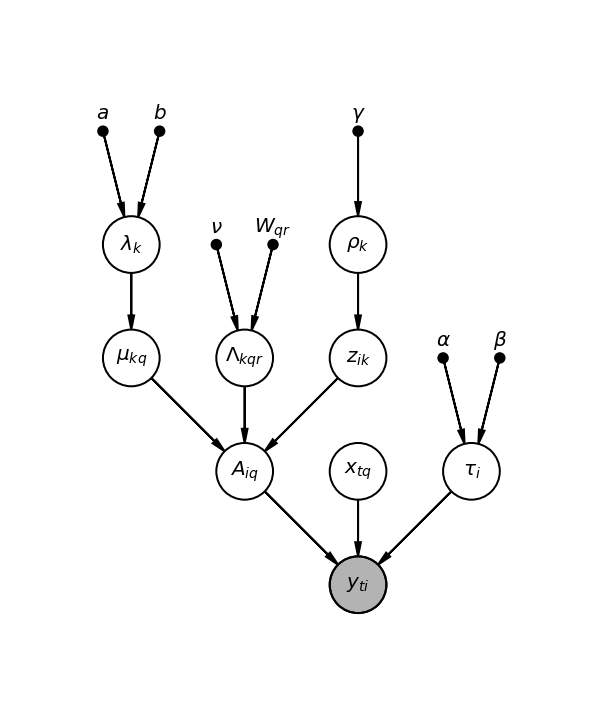

In [49]:
def create_model(**kwargs):
    pgm = daft.PGM(**kwargs)
    pgm.add_node(daft.Node('y', r'$y_{ti}$', 3, 1, observed=True))
    pgm.add_node(daft.Node('A', r'$A_{iq}$', 2, 2))
    pgm.add_node(daft.Node('x', r'$x_{tq}$', 3, 2))
    pgm.add_node(daft.Node('mu', r'$\mu_{kq}$', 1, 3))
    pgm.add_node(daft.Node('Lambda', r'$\Lambda_{kqr}$', 2, 3))
    pgm.add_node(daft.Node('z', r'$z_{ik}$', 3, 3))
    pgm.add_node(daft.Node('rho', r'$\rho_k$', 3, 4))
    pgm.add_node(daft.Node('gamma', r'$\gamma$', 3, 5, fixed=True))
    pgm.add_node(daft.Node('lambda', r'$\lambda_k$', 1, 4))
    pgm.add_node(daft.Node('a', '$a$', .75, 5, fixed=True))
    pgm.add_node(daft.Node('b', '$b$', 1.25, 5, fixed=True))
    pgm.add_node(daft.Node('nu', r'$\nu$', 1.75, 4, fixed=True))
    pgm.add_node(daft.Node('W', '$W_{qr}$', 2.25, 4, fixed=True))
    pgm.add_node(daft.Node('tau', r'$\tau_i$', 4, 2))
    pgm.add_node(daft.Node('alpha', r'$\alpha$', 3.75, 3, fixed=True))
    pgm.add_node(daft.Node('beta', r'$\beta$', 4.25, 3, fixed=True))

    pgm.add_edge('gamma', 'rho')
    pgm.add_edge('rho', 'z')
    pgm.add_edge('z', 'A')
    pgm.add_edge('mu', 'A')
    pgm.add_edge('Lambda', 'A')
    pgm.add_edge('A', 'y')
    pgm.add_edge('x', 'y')
    pgm.add_edge('lambda', 'mu')
    pgm.add_edge('a', 'lambda')
    pgm.add_edge('b', 'lambda')
    pgm.add_edge('W', 'Lambda')
    pgm.add_edge('nu', 'Lambda')
    pgm.add_edge('tau', 'y')
    pgm.add_edge('alpha', 'tau')
    pgm.add_edge('beta', 'tau')
    return pgm

pgm = create_model(shape=[5, 6])
pgm.render()

#pgm.figure.savefig('model.png')
#pgm.figure.savefig('model.pdf')

0.0

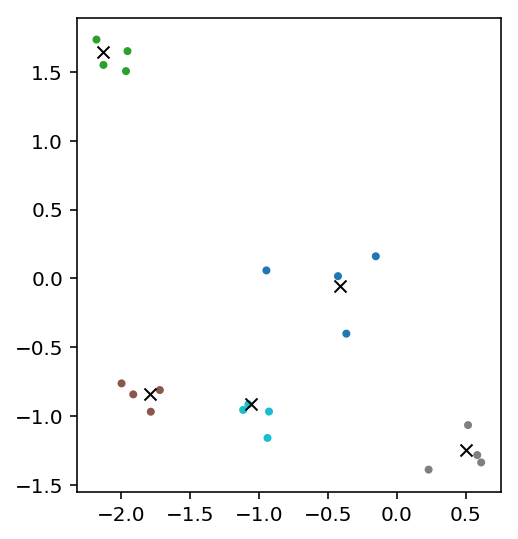

In [25]:
np.random.seed(2)
num_groups = 5
num_nodes = 20
num_factors = 2
num_obs = 19
p_missing=0

mu = np.random.normal(0, 1, (num_groups, num_factors))
Lambda = scipy.stats.wishart.rvs(50, np.eye(num_factors), num_groups)
idx = np.arange(num_nodes) % num_groups
z = np.ones((num_nodes, num_groups))
z[np.arange(num_nodes), idx] = 1
A = mu[idx] + np.einsum('ijk,ik->ij', np.linalg.cholesky(np.linalg.inv(Lambda))[idx], 
                        np.random.normal(0, 1, (num_nodes, num_factors)))
# A = np.asarray([np.random.multivariate_normal(mu[i], np.linalg.inv(Lambda[i])) for i in idx])
x = np.random.normal(0, 1, (num_obs, num_factors))
predictor = np.dot(x, A.T)
tau = np.random.gamma(100, 1 / 10, num_nodes)
y = predictor + np.random.normal(0, 1 / np.sqrt(tau), (num_obs, num_nodes))
y[np.random.uniform(size=y.shape) < p_missing] = np.nan

fig, ax = plt.subplots()
ax.scatter(*A.T, c=idx, cmap='tab10', marker='.')
ax.set_aspect(1)
ax.scatter(*mu.T, color='k', marker='x')

np.mean(np.isnan(y))

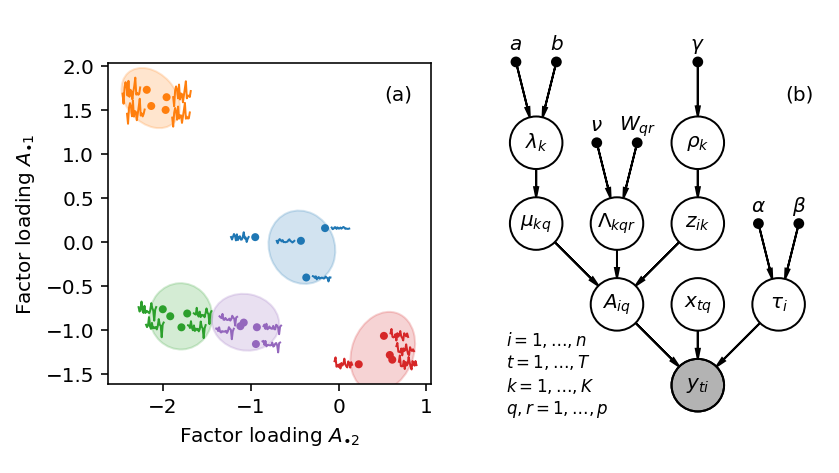

In [59]:
cmap = colors.ListedColormap(['C%d' % i for i in range(5)])
fig, (ax1, ax2) = plt.subplots(1, 2)

ax = ax1
ax.scatter(*A.T, c=idx, cmap=cmap, marker='.')
ax.set_aspect(1)
for i, (m, p) in enumerate(zip(mu, Lambda)):
    ax.add_artist(
        time_series.ellipse_from_precision(
            m, p, color='C%d' % i, alpha=0.2,
            scale=5
        )
    )
    
d = 0.075
offsets = {
    2: (0, -0.1),
    9: (0, -0.05),
    14: (0, 0.05),
    16: (-0.2 - 2 * d, -0.05),
    1: (0, 0.05),
    11: (0, -0.05),
    3: (0, 0.05),
    18: (0, -0.05),
}
lin = np.linspace(0, 0.2, num_obs)
for i in range(num_nodes):
    color = 'C%d' % idx[i]
    mx, my = mu[idx[i]]
    dx, dy = offsets.get(i, (0, 0))
    dx += -(0.2 + d) if A[i, 0] < mx else d
    
    ax.plot(A[i, 0] + lin + dx, A[i, 1] + y[:, i] * 0.02 + dy, color=color)
    #ax.text(*A[i], str(i))
    
ax.set_ylabel(r'Factor loading $A_{\bullet 1}$')
ax.set_xlabel(r'Factor loading $A_{\bullet 2}$')

pgm = create_model(shape=(4, 5), origin=(0.5, 0.5))
ctx = pgm._ctx

ax = ax2
ax.set_axis_off()
ax.set_aspect(1)
ctx.node_unit = 1.3
ctx._figure = fig
ctx._ax = ax
ctx.grid_unit = 2
pgm.render()

l0 = ctx.convert(*ctx.origin)
l1 = ctx.convert(*(ctx.origin + ctx.shape))
ax.set_xlim(l0[0], l1[0])
ax.set_ylim(l0[1], l1[1])

fig.text(0.48, 0.72, '(a)', ha='right', va='top')
fig.text(2 * 0.48, 0.72, '(b)', ha='right', va='top')

if False:
    path = patches.Polygon([(0, 4), (0, 8), (2, 8), (2, 6), (4, 6), (4, 4)], edgecolor='k', facecolor='none', clip_on=False)
    ax.add_artist(path)
    
if True:
    indices = [
        ('i', 1, 'n'),
        ('t', 1, 'T'),
        ('k', 1, 'K'),
        ('q,r', 1, 'p'),
    ]
    text = "\n".join([r'$%s=%s,\ldots,%s$' % item for item in indices])
    ax.text(.25, .25, text, fontsize='small')


fig.tight_layout()
fig.savefig('../figures/cartoon-model.png')
fig.savefig('../figures/cartoon-model.pdf')

In [60]:
converter = colors.ColorConverter()

In [61]:
for i in range(10):
    print(r"\definecolor{mpl%d}{HTML}{%s}" % (i, colors.to_hex('C%d' % i)))

\definecolor{mpl0}{HTML}{#1f77b4}
\definecolor{mpl1}{HTML}{#ff7f0e}
\definecolor{mpl2}{HTML}{#2ca02c}
\definecolor{mpl3}{HTML}{#d62728}
\definecolor{mpl4}{HTML}{#9467bd}
\definecolor{mpl5}{HTML}{#8c564b}
\definecolor{mpl6}{HTML}{#e377c2}
\definecolor{mpl7}{HTML}{#7f7f7f}
\definecolor{mpl8}{HTML}{#bcbd22}
\definecolor{mpl9}{HTML}{#17becf}
